# Склеивание панорам

В данном задании нужно из нескольких кадров, снятых из одной точки, но под разными углами, составить одну панораму.
Для этого мы будем использовать дескрипторы особых точек [ORB](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.370.4395&rep=rep1&type=pdf) и алгоритм оценки параметров модели [RANSAC](https://ru.wikipedia.org/wiki/RANSAC).

На вход алгоритм получает N кадров.

---
Семинар:

1. Находим особые точки и их дескрипторы на всех кадрах панорамы с помощью алгоритма ORB (можно использовать другой алгоритм). *1 балл*
1. Получаем преобразование между соседними кадрами с помощью алгоритма ransac *1 балл*
1. Получаем преобразование всех кадров на плоскость центрального кадра *2 балла*
1. Преобразовываем кадры так, чтобы они оказались в плоскости центрального кадра и изображаем на одном изображении. *2 балла*

---
ДЗ: Смешиваем изображения с помощью лаплассовской пирамиды. *4 балла*

Советы:
- Для ускорения обработки можно уменьшить изображения в несколько раз после загрузки.

In [138]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io

## 0. Загрузка кадров

В папке jpeg лежат подпапки 1, 2, 3, ...

Каждая подпапка - набор кадров, которые вам предстоит склеить. Давайте откроем одну из папок и увидим, что у нее внутри.

In [139]:
FIGSIZE = (15, 10)
COLUMNS = 3
ROWS = 3

def plot_collage(imgs, columns=COLUMNS, rows=ROWS, figsize=FIGSIZE, title=None):
    fig = plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title)
        plt.axis('off')
    
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i-1], interpolation='nearest')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [140]:
pano_image_collection = io.ImageCollection('jpeg/lowres/8_*.jpg',
                                           load_func=lambda f: io.imread(f).astype(np.float32) / 255)
# plot_collage(pano_image_collection, title=f"Image collection size: {len(pano_image_collection)}")

## 1. Выделение ключевых точек (1 балл)

Для начала найдем ключевые точки на каждом кадре.
Если на последующих этапах качество совмещения будет недостаточным, настройте параметры алгоритма ORB.

In [141]:
from skimage.feature import ORB
from skimage.color import rgb2gray

def find_orb(img, n_keypoints=2000, **args):
    """Найти ключевые точки и их дескрипторы на изображении.
    
    img (np.array WxHx3) трехканальное изображение
    n_keypoints (int) число ключевых точек, которые нужно найти на изображении
    **kwargs (dict) остальные параметры, передаются в ORB без изменений
    
    Return: tuple (2,) координаты и дескриторы ключевых точек
    """
    detector_extractor = ORB(n_keypoints, **args)
    gray = rgb2gray(img)
    detector_extractor.detect_and_extract(gray)
    return detector_extractor.keypoints, detector_extractor.descriptors

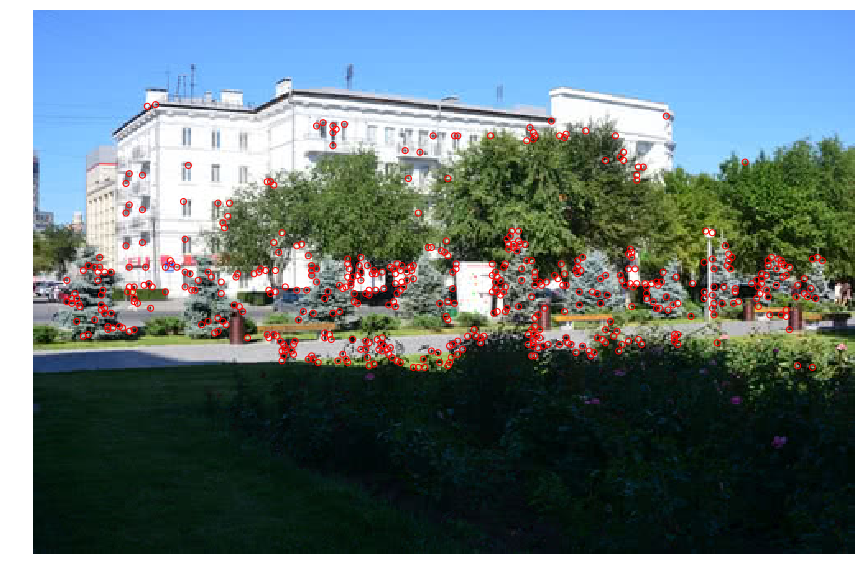

In [142]:
# Выводим первое изображение и ключевые точки на нем
img = pano_image_collection[0]
plt.figure(figsize=FIGSIZE)
plt.imshow(img)
plt.axis('off')

keypoints, descriptors = find_orb(img)

plt.scatter(keypoints[:, 1], keypoints[:, 0], facecolors='none', edgecolors='r')

## 2. Получаем преобразование между соседними кадрами с помощью алгоритма ransac (1 балл)

На основе функции извлечения ключевых точек построим алгоритм поиска соответствий между соседними кадрами.

Можно предполагать, что изображения размещены в порядке съемки слева направо.

In [143]:
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform, AffineTransform
from skimage.measure import ransac

# Будем использовать дальше
DEFAULT_TRANSFORM = ProjectiveTransform

def find_robust_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors,
                          return_matches=False,
                          model_class=DEFAULT_TRANSFORM, min_samples=4, residual_threshold=1, 
                          max_trials=5000, **kwargs):
    """Найти соответствие между двумя кадрами панорамы.
    
    src_keypoints, dest_keypoints - координаты ключевых точек
    src_descriptors, dest_descriptors - дескрипторы ключевых точек
    model_class, min_samples, residual_threshold, **kwargs - параметры алгоритма ransac
     - model_class - используемая модель преобразования плоскости
     - min_samples - необходимое число точек для построения преобразования.
                     Чем сложнее модель, тем больше нужно точек.
                     Про конкретную модель можно прочитать в документации.
     - residual_threshold - какое расстояние в пикселях между точками считать совпадением.
     - max_trials - какое количество попыток можно сделать, прежде чем остановиться.
                    Чем больше точек мы хотим сопоставить, тем больше должно быть это число.
     - **kwargs - Остальные параметры
     
    
    Return: tuple (2, )
    result[0]: преобразование, переводящее 1 кадр в плоскость второго
    result[1]: сопоставление точек (исключая выбросы)
    """
    
    matches = match_descriptors(src_descriptors, dest_descriptors)
    ransac_model, inliers = ransac((src_keypoints[matches[:, 0]], dest_keypoints[matches[:, 1]]),
                                   model_class, min_samples, residual_threshold, max_trials=max_trials,
                                   **kwargs)

    return ransac_model, matches[inliers, :]

C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:554: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 0] /= dst[:, 2]
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:555: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 1] /= dst[:, 2]
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\measure\fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:554: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 0] /= dst[:, 2]


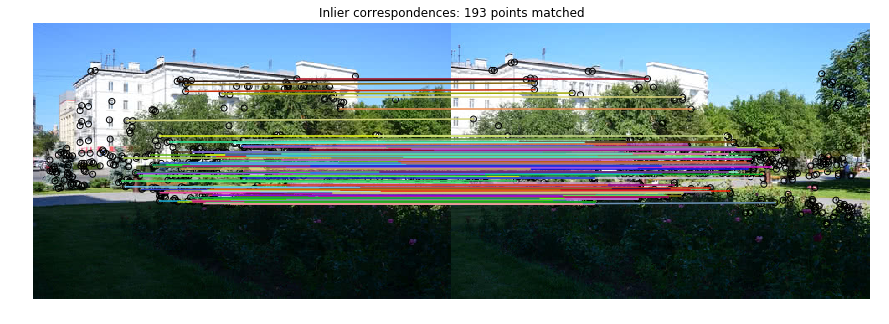

In [144]:
# Проверка работы функции поиска преобразований соседних кадров
from skimage.feature import plot_matches

src, dest = pano_image_collection[0], pano_image_collection[1]

src_keypoints, src_descriptors = find_orb(src)
dest_keypoints, dest_descriptors = find_orb(dest)

robust_transform, matches = find_robust_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, return_matches=True)

# Visualize the results.
plt.figure(figsize=FIGSIZE)
ax = plt.axes()
ax.axis("off")
ax.set_title(f"Inlier correspondences: {len(matches)} points matched")

plot_matches(ax, src, dest, src_keypoints, dest_keypoints,
             matches)

plt.show()

In [145]:
# Найдем попарные преобразования между каждыми кадрами и сохраним в массив diff_warps
keypoints, descriptors = zip(*(find_orb(img) for img in pano_image_collection))
forward_transforms = tuple(find_robust_transform(src_kp, src_desc, dest_kp, dest_desc)
                           for src_kp, src_desc, dest_kp, dest_desc 
                           in zip(keypoints[:-1], descriptors[:-1], keypoints[1:], descriptors[1:]))

C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:554: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 0] /= dst[:, 2]
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:555: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 1] /= dst[:, 2]
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:554: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 0] /= dst[:, 2]
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\measure\fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:555: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 1] /= dst[:, 2]


## 3. Получаем преобразование всех кадров на плоскость центрального кадра (2 балла)

Так как на крайних кадрах может не быть одинаковых объектов, нам придется сначала искать преобразование между соседними кадрами, а потом строить преобразование, которое каждый кадр приведет на плоскость среднего кадра.

Hints:
- Преобразования skimage можно складывать.
- Первая строчка может вам понадобиться.

In [146]:
from numpy.linalg import inv

def find_simple_center_warps(forward_transforms):
    """Найдем преобразование, которое каждый кадр коллекции приведет на плоскость среднего кадра.
    diff_warps: Tuple[N] - попарные преобразования кадров
    return List[N + 1] - преобразования каждого кадра в плоскость центрального кадра
    """
    image_count = len(forward_transforms) + 1 # сколько всего изображений
    center_index = (image_count - 1) // 2 # какой индекс у центральной картинки
    
    result = [None] * image_count
    result[center_index] = DEFAULT_TRANSFORM()
    
    for i in range(center_index + 1, image_count):
        tmp_transform = forward_transforms[i-1][0].inverse
        # tmp_transform.params = inv(tmp_transform.params)
        result[i] = result[i - 1] + tmp_transform
        
    for i in range(center_index - 1, -1, -1):
        result[i] = result[i + 1] + forward_transforms[i][0]
    
    return tuple(result)

Text(0.5,1,'Border visualization')

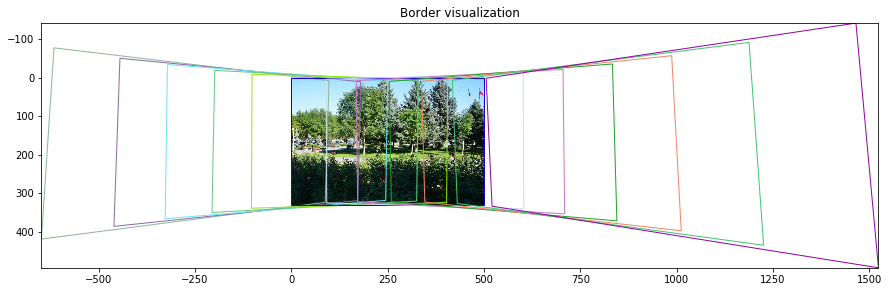

In [147]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

np.random.seed(0)
plt.figure(figsize=FIGSIZE)
ax = plt.axes()

def get_corners(image_collection, center_warps):
    """Получаем координаты углов каждого кадра после преобразований."""
    for img, transform in zip(pano_image_collection, center_warps):
        height, width, _ = img.shape
        corners = np.array([[0, 0],
                            [height, 0],
                            [height, width],
                            [0, width]
                           ])

        yield transform(corners)[:, ::-1]

def get_min_max_coords(corners):
    """Получаем минимальный и максимальные координаты углов."""
    corners = np.concatenate(corners)
    return corners.min(axis=0), corners.max(axis=0)  

# Проверка
simple_center_warps = find_simple_center_warps(forward_transforms)
corners = tuple(get_corners(pano_image_collection, simple_center_warps))

for coords in corners:
    ax.add_patch(Polygon(coords, closed=True, fill=False, color=np.random.rand(3)))

min_coords, max_coords = get_min_max_coords(corners)
plt.xlim(min_coords[0], max_coords[0])
plt.ylim(max_coords[1], min_coords[1])

center_index = (len(pano_image_collection) - 1) // 2
plt.imshow(pano_image_collection[center_index])

plt.title('Border visualization')

Однако, как мы видим, часть изображения ушла в отрицательную часть плоскости, а часть вышла за рамки центрального изображения. Если мы сейчас начнем соединять изображения, то все за рамками центрального изображения будет обрезано.

Нам нужно:
- Получить такие преобразования, которые отправляли бы изображение в положительную четверть.
- Рассчитать размер финального изображения

In [148]:
from skimage.transform import SimilarityTransform

def get_final_center_warps(image_collection, simple_center_warps):
    
    translation_transform = SimilarityTransform(translation = - min_coords[::-1])
    
    count = len(simple_center_warps)
    final_center_warps = [None] * count
    for i in range(count):
        final_center_warps[i] = simple_center_warps[i] + translation_transform
    
    output_shape = (max_coords[::-1] - min_coords[::-1]).astype(int)
    
    return final_center_warps, tuple(output_shape)

Text(0.5,1,'Border visualization')

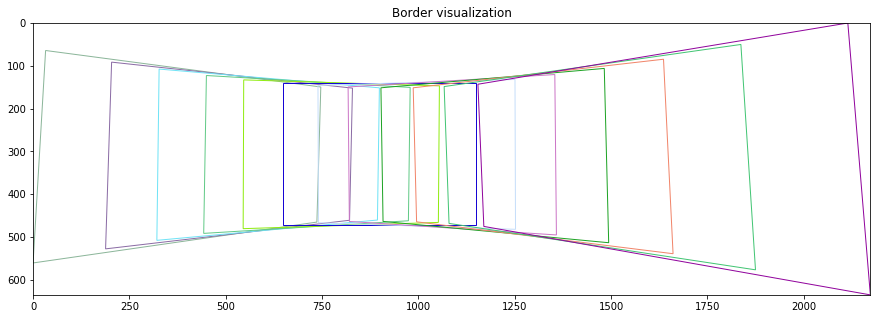

In [149]:
np.random.seed(0)
plt.figure(figsize=(15, 5))
ax = plt.axes()

# Проверка
final_center_warps, output_shape = get_final_center_warps(pano_image_collection, simple_center_warps)
corners = tuple(get_corners(pano_image_collection, final_center_warps))

for coords in corners:
    ax.add_patch(Polygon(coords, closed=True, fill=False, color=np.random.rand(3)))

plt.xlim(0, output_shape[1])
plt.ylim(output_shape[0], 0)

plt.title('Border visualization')

## 4. Преобразовываем кадры так, чтобы они оказались в плоскости центрального кадра и соединяем на одном изображении (2 балла)
Теперь пришло время слить все изображения в одну панораму.

Для этого реализуйте функцию слияния двух фотографий: на вход вы получаете новый кадр и его маску, а также результат и его маску. Вам необходимо обновить результат и маску.

Советы:
- Обратите внимание, что мы поворачиваем матрицу преобразования, т.к. она рассчитывается в координатах xy, а работа с изображениями идет в координатах row:col (yx).
- У функции warp есть параметр cval.

In [150]:
from skimage.transform import warp

def rotate_transform_matrix(transform):
    """Сделаем так, чтобы трансформация считалась в координатах row:col."""
    matrix = transform.params[(1, 0, 2), :][:, (1, 0, 2)]
    return type(transform)(matrix)

def warp_image(image, transform, output_shape):
    """Применить преобразование к изображению и вернуть преобразованное изображение и маску.
    
    image: изображение для преобразования
    transform: преобразование
    output_shape: размер результата
    
    return: tuple (2, )
        np.array (h, w, 3) преобразованное изображение
        np.array (h, w) маска        
    """
    
    rotated_transform = rotate_transform_matrix(transform).inverse
    result = warp(image, rotated_transform, output_shape=(*output_shape, 3), cval=-1)
    mask = np.zeros(output_shape)
    mask[result[:, :, 0] != -1] = 1
    result[result == -1] = 0
    
    return result, mask


def navy_merge_pano(image_collection, final_center_warps, output_shape):
    """Склеим панораму из нескольких изображений.
    
    image_collection: набор изображений для склеивания
    final_center_warps: преобразования, которые переводят все кадры на плоскость центрального кадра
    output_shape: размер панорамы
    
    return: np.array (*output_shape, 3) изображение, на котором совмещены все кадры.
    """
   
    merged_img = np.zeros((*output_shape, 3))
    sum_mask = np.zeros(output_shape, dtype=int)
    count = len(image_collection)
    
    for i in range(count):
        img, mask = warp_image(image_collection[i], final_center_warps[i], output_shape)
        merged_img = merged_img + img
        sum_mask = sum_mask + mask
    
    sum_mask[sum_mask == 0] = 1
    
    merged_img[:, :, 0] = merged_img[:, :, 0] / sum_mask
    merged_img[:, :, 1] = merged_img[:, :, 1] / sum_mask
    merged_img[:, :, 2] = merged_img[:, :, 2] / sum_mask
    
    return merged_img

(-0.5, 2171.5, 634.5, -0.5)

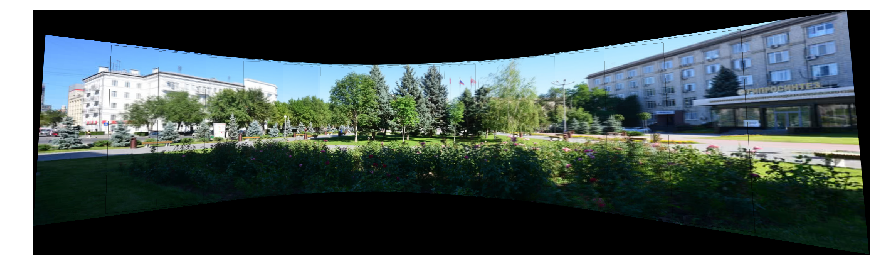

In [151]:
plt.figure(figsize=FIGSIZE)

result = navy_merge_pano(pano_image_collection, final_center_warps, output_shape)
plt.imshow(result)
plt.axis('off')

*конец семинара*

---

## 5. ДЗ: Смешиваем изображения с помощью лаплассовской пирамиды (4 балла)

Можно заметить, что на границе кадров возникают черные линии, а объекты стыкуются неидеально.

Для смешивания нескольких кадров можно применить лаплассову пирамиду. Давайте реализуем ее.

In [152]:
from skimage.filters import gaussian

def get_gaussian_pyramid(image, n_layers=4, sigma=2):
    """Построить набор изображений, рекурсивно обработанный с помощью гауссианы.
    
    image: np.array (h, w, 3)
    n_layers: количество слоев в пирамиде гауссиан
    sigma: gaussian sigma
    
    """
    for i in range(n_layers):
        image = gaussian(image, sigma=sigma)
        yield image
    

def get_laplassian_pyramid(image, n_layers=4, sigma=2):
    """Представить изображение в виде лаплассовской пирамиды.
    
    image: np.array (h, w, 3)
    n_layers: количество слоев в пирамиде гауссиан
    sigma: gaussian sigma
    
    return: tuple(n_layers, ) of np.array (h, w, 3) лаплассовская пирамида
    """
    
    result = [None] * (n_layers + 1)
    gaussian_pyramid = get_gaussian_pyramid(image, n_layers, sigma)
    for i in range(n_layers):
        result[i] = image
        image = next(gaussian_pyramid)
        result[i] = result[i] - image
        
    result[n_layers] = image
        
    return tuple(result)


def merge_laplassian_pyramid(gaussian_pyramid):
    """Собрать из пирамиды гауссиан исходное изображение.
    
    gauss_pyramid: tuple of np.array (h, w, 3)
    return: np.array (h, w, 3) image
    """
    
    result = gaussian_pyramid[0].copy()
    for i in range (1, len(gaussian_pyramid)):
        result = result + gaussian_pyramid[i]
    
    return result

C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


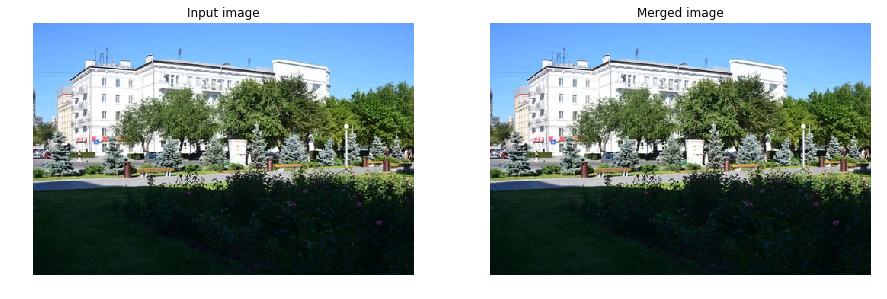

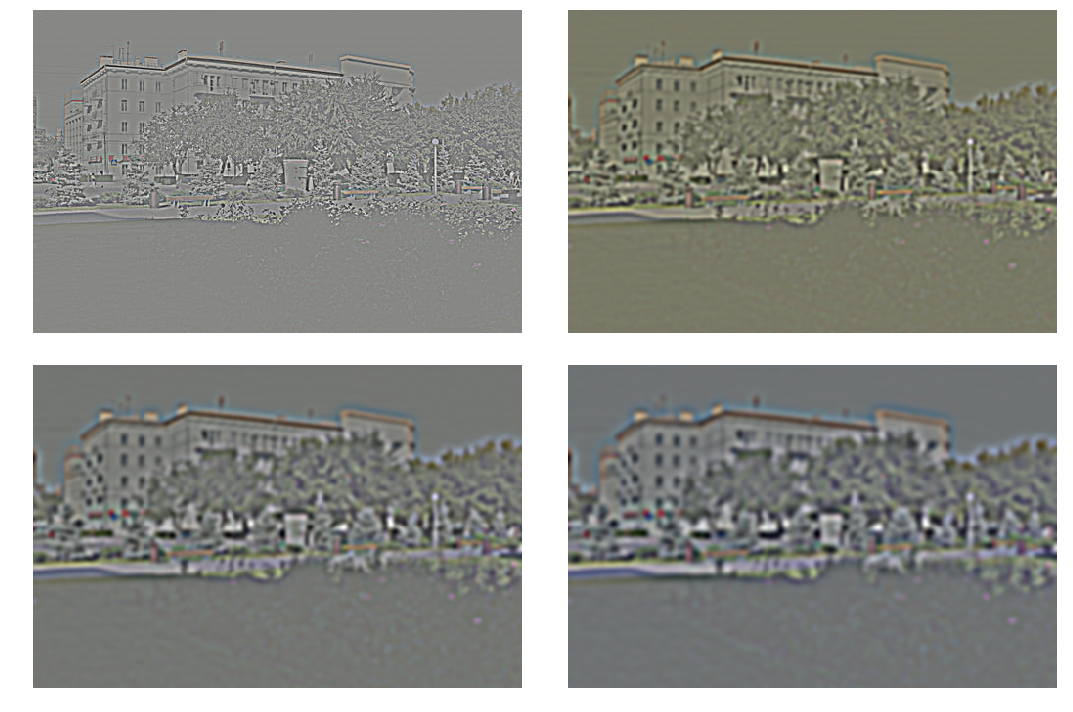

In [153]:
img = pano_image_collection[0]

from skimage.io import imsave

def increase_contrast(image_collection):
    result = []
    
    for img in image_collection:
        img = img.copy()
        for i in range(img.shape[-1]):
            img[:, :, i] -= img[:, :, i].min()
            img[:, :, i] /= img[:, :, i].max()
        result.append(img)
    
    return result

gaussian_pyramid = get_laplassian_pyramid(img)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Input image')
plt.axis('off')
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title('Merged image')
plt.axis('off')
merged_img = merge_laplassian_pyramid(gaussian_pyramid)
merged_img = increase_contrast( [merged_img] )[0]
plt.imshow(merged_img)

plot_collage(increase_contrast(gaussian_pyramid), columns=2, rows=2)

In [154]:
def gaussian_merge_pano(image_collection, final_center_warps, output_shape, n_layers=4, image_sigma=2, merge_sigma=10):
    """Склеим панораму из нескольких изображений.
    Здесь нужно реализовать склеивание с использованием пирамиды гауссиан.
    """
    count = len(image_collection)
    ls = np.zeros((n_layers + 1, *output_shape, 3))
    masks = np.zeros((n_layers + 1, *output_shape)) 
        
    for i in range(count):
        warped_image,  warped_mask = warp_image(image_collection[i], final_center_warps[i], output_shape)
        laplassian_pyramid = get_laplassian_pyramid(warped_image, n_layers, image_sigma)
        mask_gen = get_gaussian_pyramid(warped_mask, n_layers + 1, merge_sigma)
        for j in range(n_layers + 1):
            mask = next(mask_gen)
            mask[warped_mask == 0] = 0
            ls[j] += laplassian_pyramid[j] * np.dstack((mask, mask, mask))
            masks[j] += mask
    
    masks[masks == 0] = 1
    for j in range(n_layers + 1):
        ls[j] /= np.dstack((masks[j], masks[j], masks[j]))

    merged_img = merge_laplassian_pyramid(tuple(ls))
    merged_img = increase_contrast( [merged_img] )[0]
    
    return merged_img

C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


(-0.5, 2171.5, 634.5, -0.5)

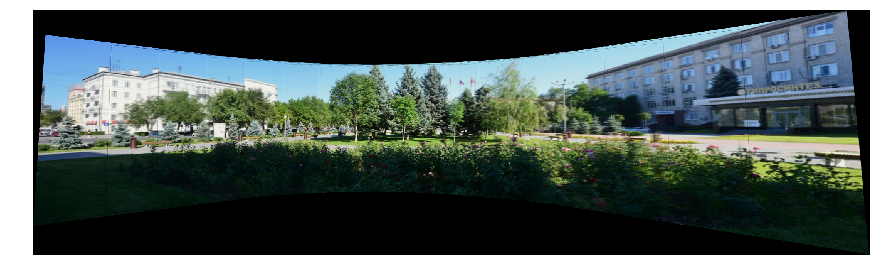

In [155]:
plt.figure(figsize=FIGSIZE)
from skimage.io import imsave

result = gaussian_merge_pano(pano_image_collection, final_center_warps, output_shape)
plt.imshow(result)
plt.axis('off')

In [156]:
# Соберем все вместе!
def merge_pano(image_collection):
    keypoints, descriptors = zip(*(find_orb(img) for img in image_collection))
    forward_transforms = tuple(find_robust_transform(src_kp, src_desc, dest_kp, dest_desc)
                               for src_kp, src_desc, dest_kp, dest_desc 
                               in zip(keypoints[:-1], descriptors[:-1], keypoints[1:], descriptors[1:]))
    simple_center_warps = find_simple_center_warps(forward_transforms=forward_transforms)
    final_center_warps, output_shape = get_final_center_warps(image_collection=image_collection, 
                                                              simple_center_warps=simple_center_warps)
    return gaussian_merge_pano(image_collection=image_collection, 
                               final_center_warps=final_center_warps, 
                               output_shape=output_shape)

C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:554: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 0] /= dst[:, 2]
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:555: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 1] /= dst[:, 2]
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\measure\fit.py:831: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:554: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 0] /= dst[:, 2]
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:555: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 1] /= dst[:, 2]
C:\Users\Ekaterina\Anaconda3\lib\site-packages\skimage\filters\_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interp

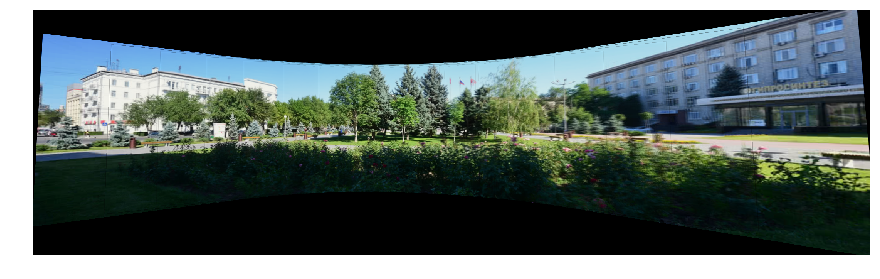

In [157]:
plt.figure(figsize=FIGSIZE)

result = merge_pano(pano_image_collection)
plt.imshow(result)
plt.axis('off')
plt.imsave('result.png', result)

## Результат

Результат своей работы вы можете скачать [по ссылке](result.png)

## Дальнейшее развитие

За рамками этого вводного занятия алгоритм склейки панорам можно развивать следующими способами:

1. Для избежания искажений нужно написать свой класс преобразования, который выполняет не проективное преобразование, а проекцию на цилиндр или сферу. Нужно реализовать методы `__call__`, `estimate`, `inverse`, `__add__`. 
1. Для корректной обработки проекции на сферу нужно научиться находить соответствие между кадрами без заданного порядка. Если мы хотим снять и землю, и небо, и большой участок по горизонтали, то придется искать соответствие между кадрами.
1. Цветокоррекция: на участках неба заметна граница между кадрами.

### См. также

- На странице [release](https://github.com/vslutov/panorama-public/releases) можно скачать фотографии в большом разрешении.
- В папке [jpeg/lowres](jpeg/lowres) лежат еще фотографии, которые можно использовать для создания панорам. Попробуйте соеденить их.

In [158]:
# your code here